In [2]:
import pickle
import math
import tqdm

import pandas as pd
import numpy as np
import keras.backend as K
from keras.models import Model
from keras import layers
from keras import optimizers
from keras import initializers
import matplotlib.pyplot as plt
from pycox.evaluation import EvalSurv

Using TensorFlow backend.


### Define functions for general use

In [4]:
def filter_relevant_contragent(t, y, t_i, y_i):
    
    """
    According to definition of Harell's C-index return indices of comparable pairs
    for observation with label y_i and time-to-event t_i
    """
    
    if y_i == 0:
        ind_y = np.where(y == 1)[0]
        ind_t = np.where(t < t_i)[0]
        ind = np.intersect1d(ind_y, ind_t)
    else:
        ind_y1 = np.where(y == 1)[0]
        ind_y2 = np.where(y == 0)[0] 
        ind_t2 = np.where(t > t_i)[0]        
        ind = np.union1d(ind_y1, np.intersect1d(ind_y2, ind_t2))   
    return ind


def get_time_bins(t, n_time_bins):

    """
    Get equal size bins
    """
    
    percent_list = np.linspace(0, 100, n_time_bins + 1, dtype=np.int)
    bins = np.percentile(a=t, q=percent_list[1:-1])
    q = np.digitize(t, bins)
    if n_time_bins != np.unique(q).shape[0]:
        raise Exception("There is too large value for n_time_bins selected")
    return q

def custom_activation(wb_params):
    
    alpha = K.exp(wb_params[:, 0])
    beta = K.softplus(wb_params[:, 1])
    
    beta = K.reshape(beta, (K.shape(beta)[0], 1))
    alpha = K.reshape(alpha, (K.shape(alpha)[0], 1))
    
    return K.concatenate((alpha, beta), axis=1)

def WeibullRankingModel(input_shape, common_nn_input, common_nn_output, loss, optimizer):
    
    # build Siamese network    
    wp = layers.Dense(2, activation=None, name='weibull_params')(common_nn_output)
    wp = layers.Activation(custom_activation)(wp)
    base_network = Model(common_nn_input, wp)
    
    input_a = layers.Input(shape=input_shape)
    input_b = layers.Input(shape=input_shape)
    
    processed_a = base_network(input_a)
    processed_b = base_network(input_b)
    merged_vector = layers.concatenate([processed_a, processed_b], axis=-1)
    model = Model([input_a, input_b], merged_vector)
    
    # complilation
    if loss == 'binary_ce':
        loss_f = binary_cross_entropy_survival
        batch_generator = binary_cross_entropy_batch_generator
    model.compile(optimizer=optimizer, loss=loss_f)
    
    return model, batch_generator


### Define specific functions: binary case loss and batch generator

In [5]:
def binary_cross_entropy_survival(y_true, y_pred):
    
    """
    y_pred (, 4) - output of network
        y_pred[:, 0:2] - weibull parameters for first input
        y_pred[:, 2:4] - weibull parameters for second input
    y_true (, 4) - target
        y_true[:, 0] - t for first input
        y_true[:, 1] - t for second input  
        y_true[:, 2] - target (1 if q1 == q2 and 0 otherwise)
        y_true[:, 3] - sample weight 
    """
    
    # get a probaility    
    t_a = y_true[:, 0]
    t_b = y_true[:, 1]
    o = y_true[:, 2]
    q = y_true[:, 3]
    
    y_pred_a = y_pred[:, 0:2]
    y_pred_b = y_pred[:, 2:4]

    s_a = calc_survival_value(t_a, y_pred_a)
    s_b = calc_survival_value(t_b, y_pred_b)
    sigm = K.sigmoid(s_a - s_b)
    sigm = K.clip(sigm, K.epsilon(), 1 - K.epsilon())
    
    # weighted binary cross entropy
    label_pos = o * K.log(sigm + K.epsilon())
    label_neg = (1 - o) * K.log(1 + K.epsilon() - sigm) * (q + 1)  
    print(s_a)
    print(s_b)
    return -1 * K.mean(label_pos + label_neg)

   
def calc_survival_value(y_true, y_pred):
    
    alphas = y_pred[:, 0]
    betas = y_pred[:, 1]
    # TODO: clipping     sigm = K.clip(sigm, K.epsilon(), 1 - K.epsilon())
    s = K.exp(-1 * K.pow(y_true / (alphas + 1e-6), betas))
              
    return s                                              


def binary_cross_entropy_batch_generator(x, t, y, n_time_bins=10, batch_anchors=1, anchor_pairs=2):
    
    # TODO: баланс классов (убедиться, что будет генерироваться и положительные и отрицательные примеры, 
    # с одинаковой вероятностью берем бины справа и слева от бина исходного примера)
    # TODO: предрасчитать то, что можно не пересчитывать каждый раз  
    
    """
    Keyword arguments:
    sample_weight - is it needed to weight examples proportionally to time bin during sampling and training
     # sample_weight - q для train_on_batch
    """
    assert anchor_pairs > 1
    x_batch_left = np.zeros((batch_anchors * anchor_pairs, x.shape[1]))
    x_batch_right = np.zeros((batch_anchors * anchor_pairs, x.shape[1]))
    y_batch = np.zeros((batch_anchors * anchor_pairs, 4))
    sample_weight = np.zeros((batch_anchors * anchor_pairs, 1))
    q = get_time_bins(t=t, n_time_bins=n_time_bins)
    
    # uniform sampling of time bins
    bins = np.random.uniform(0, n_time_bins - 1, batch_anchors).astype(int)
    # for each anchor
    i = 0
    for b in bins:
        ind_anchor = np.random.choice(np.where(q == b)[0], 1, replace=False)[0]
        x_anchor = x[ind_anchor, :]
        t_anchor = t[ind_anchor]
        y_anchor = y[ind_anchor]
        x_batch_left[(anchor_pairs * i):(anchor_pairs * i + anchor_pairs), :] = x_anchor
        y_batch[(anchor_pairs * i):(anchor_pairs * i + anchor_pairs), 0] = t_anchor
        # find possible pair
        ind_pos_contr = filter_relevant_contragent(t, y, t_anchor, y_anchor)
        dq = q[ind_pos_contr] - q[ind_anchor] 
        # half of times from the same bin and the other half - uniformly from all bins
        n_obs_same_bin = dq[dq == 0].shape[0]
        n_obs_same_bin = min(n_obs_same_bin, anchor_pairs // 2)
        if n_obs_same_bin == 0:
            pairs_bins = np.random.uniform(np.min(dq), np.max(dq), anchor_pairs).astype(int)
        else:
            pairs_bins = np.repeat(0, repeats=n_obs_same_bin)
            pairs_bins = np.append(pairs_bins, np.random.uniform(np.min(dq), np.max(dq), anchor_pairs - n_obs_same_bin).astype(int))
        # TODO: proportional sampling
        # for each pair
        j = 0        
        for p_b in pairs_bins:
            ind_pair = np.random.choice(np.where(dq == p_b)[0], 1, replace=False)[0]
            x_batch_right[i * anchor_pairs + j, :] = x[ind_pos_contr, :][ind_pair]
            y_batch[i * anchor_pairs + j, 1] = t[ind_pos_contr][ind_pair]
            y_batch[i * anchor_pairs + j, 2] = np.int(dq[ind_pair] == 0)
            y_batch[i * anchor_pairs + j, 3] = 1 + abs(dq[ind_pair]) / n_time_bins
            j += 1
        i += 1

    yield [x_batch_left, x_batch_right], y_batch


In [13]:
[x_batch_left, x_batch_right], y_batch = next(binary_cross_entropy_batch_generator(
    x_val, t_val, y_val, n_time_bins=10, batch_anchors=20, anchor_pairs=4))

### Test model on METABRIC data

In [8]:
with open('../data/metabric.pkl', 'rb') as f:
    all_metabric_data = pickle.load(f)

In [9]:
[
    (x_train, y_train),
    (x_test, y_test),
    (x_val, y_val)
] = all_metabric_data

In [10]:
t_train = y_train[:, 0]
y_train = y_train[:, 1]

t_test = y_test[:, 0]
y_test = y_test[:, 1]

t_val = y_val[:, 0]
y_val = y_val[:, 1]

In [11]:
def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input = layers.Input(shape=input_shape, name='input')
    output = layers.Dense(4, activation='relu', name='dense')(input)
    return input, output


In [12]:
inp_shape = (x_train.shape[1], )
inp, outp = create_base_network(input_shape=inp_shape)
rms = optimizers.RMSprop()

In [14]:
model, batch_generator = WeibullRankingModel(input_shape=inp_shape, common_nn_input=inp, common_nn_output=outp, loss='binary_ce', optimizer=rms)
model.summary()




Tensor("loss/concatenate_1_loss/Exp:0", shape=(?,), dtype=float32)
Tensor("loss/concatenate_1_loss/Exp_1:0", shape=(?,), dtype=float32)
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 9)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 9)            0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 2)            50          input_1[0][0]                    
                                                                 input_2[0][0]                    
____________________________________________________

In [15]:
n_epochs = 30
batch_anchors = 30
n_time_bins = 10
anchor_pairs = 7

In [16]:
loss = []
for epoch in tqdm.tqdm(range(n_epochs)):
    [x_batch_left, x_batch_right], y_batch = next(batch_generator(
        x_train, t_train, y_train, n_time_bins=n_time_bins, batch_anchors=batch_anchors, anchor_pairs=anchor_pairs))
    hist = model.train_on_batch(x=[x_batch_left, x_batch_right], y=y_batch)
    loss.append(hist)

  0%|          | 0/30 [00:00<?, ?it/s]

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



100%|██████████| 30/30 [00:04<00:00,  6.54it/s]


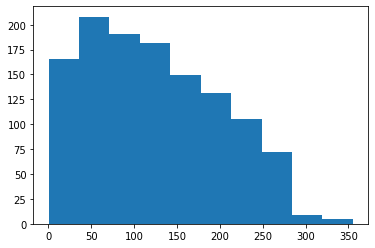

In [17]:
plt.hist(t_train);

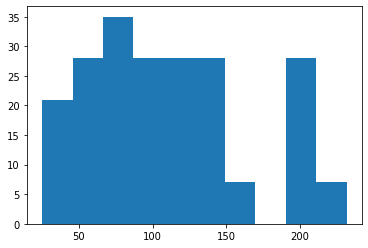

In [19]:
plt.hist(y_batch[:, 0]);

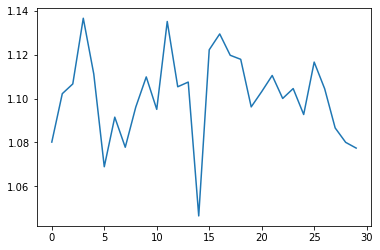

In [20]:
plt.plot(loss);

In [22]:
test_pred_wp = model.predict([x_test, x_test])[:, 0:2]

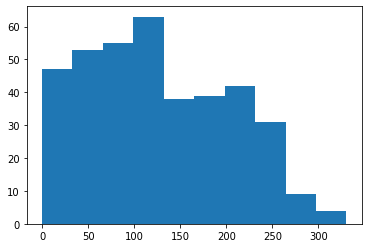

In [23]:
plt.hist(t_test);

In [39]:
dif_times = np.linspace(0, 300, 30, dtype=np.int)

all_surv_time = pd.DataFrame()
for t in dif_times:
    surv_prob = K.eval(calc_survival_value(y_true=np.repeat(t, t_test.shape[0]), y_pred=test_pred_wp))
    all_surv_time = pd.concat([all_surv_time, pd.DataFrame(surv_prob).T])

all_surv_time.index = dif_times

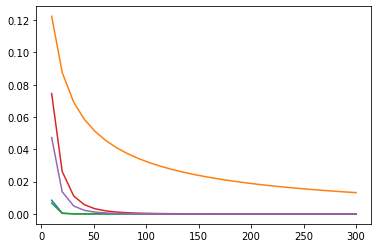

In [57]:
d = all_surv_time.sample(5, axis=1).loc[1:]
obs = d.columns
for o in obs:
    plt.plot(d.index, d[o])

In [73]:
ev1 = EvalSurv(surv=all_surv_time, durations=t_test, events=y_test, censor_surv='km')

In [74]:
ev1.concordance_td('antolini')

0.4481961931408707

Compare with baseline model - same general population alpha-beta

In [54]:
# Paramaeters for output activation layer initialization.
# Start at naive geometric (beta=1) MLE:
tte_mean_train = np.nanmean(t_train)
init_alpha = -1.0 / np.log(1.0 - 1.0 / (tte_mean_train + 1.0) )
mean_u = np.nanmean(y_train)
init_alpha = init_alpha / mean_u
print('init_alpha: ', init_alpha, 'mean uncensored: ', mean_u)

init_alpha:  205.33489420694383 mean uncensored:  0.6042692939244664


In [67]:
baseline_surv_time = pd.DataFrame()

for t in dif_times:
    bas_s = K.eval(calc_survival_value(y_true=np.array([t]), y_pred=np.array([[init_alpha, 1]])))
    baseline_surv_time = pd.concat([baseline_surv_time, pd.DataFrame(np.repeat(bas_s[0], t_test.shape[0])).T])

baseline_surv_time.index = dif_times

In [69]:
ev = EvalSurv(surv=baseline_surv_time, durations=t_test, events=y_test, censor_surv='km')

In [70]:
ev.concordance_td('antolini')

0.0

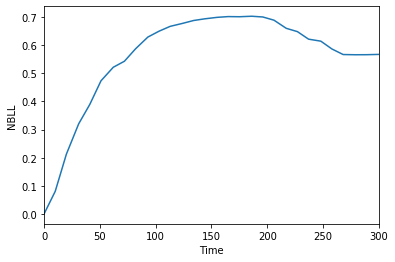

In [83]:
ev.nbll(dif_times).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

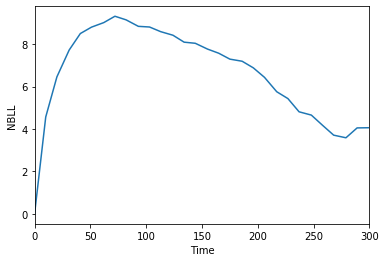

In [84]:
ev1.nbll(dif_times).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

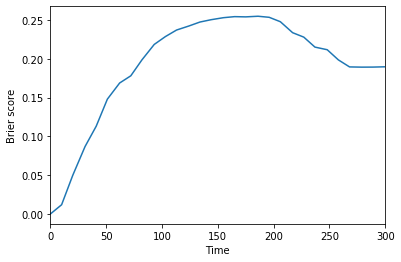

In [85]:
ev.brier_score(dif_times).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

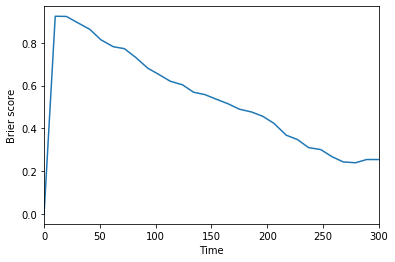

In [86]:
ev1.brier_score(dif_times).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

TODO

In [ ]:
# TODO: в лосс добавить правдоподобие (первого и второго примера)
# TODO: sample_weight подавать отдельно из батч-генератора, применять веса в train_on_batch(sample_weight),а четвертый вход в target - y
# TODO: организовать batch_generator так, чтобы 1 его вызов - 1 эпоха - все возможные примеры использованы как anchor
# TODO: регулировка batch_size
# TODO: инициализация параметров 

In [ ]:
# какие стратегии лучше и быстрее учатся????